<div style="font-size:1.4em; margin-bottom:2em">
    <div style="float:right; line-height:1.2em;">GET Lab<br />Paderborn University</div>
  <div>SS 2021</div>
</div>
<div style="clear:both"></div>
<div style="text-align:center; font-size:1.8em;">
  Digital Image Processing II<br />Task Sheet 7
</div>

<hr>

### Overview

We can distinguish two different concepts of motion on the 2D image plane: the motion (vector) field and the optical flow field (or just optical flow). The motion field is the projection of the 3D motion of objects and of the camera on the 2D image plane. In contrast, the optical flow is the *apparent motion* of image parts. Therefore, the optical flow describes the variation of pixel intensities in space and time (spatio-temporal variations). The optical flow can be identical to the motion field, but this cannot be guaranteed (see lecture notes).

The central equation for optical flow estimation is the *motion constraint* or *optical flow equation*:

$$I_x u + I_y v + I_t = 0$$

In this equation, $I_x$ and $I_y$ are the image derivatives with respect to $x$ and $y$, respectively, and $I_t$ is the image derivative with respect to the time $t$. The variables $u$ and $v$ are the optical flow corresponding to the velocities in $x$ and $y$ direction, respectively. The optical flow equation from above can be determined based on the *brightness constancy constraint* (assuming that the intensity remains unchanged along a motion trajectory) and the *small displacement assumption* (assuming small translational motion so that a Taylor expansion can be applied).

The derivatives $I_x$, $I_y$ and $I_t$ can be computed directly for each pixel by finite differences (usually by the volumetric scheme as shown in the lecture notes). The variables $u$ and $v$ are unknown. As we have one equation with two unknowns, optical flow is an under-determined problem. Practically, this becomes apparent as the aperature problem.

---

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

dpi = plt.rcParams['figure.dpi']

# plot image in original size
def plot_img_orig(img):
    fig = plt.figure(figsize = (img.shape[1]/dpi, img.shape[0]/dpi))
    fig.add_axes([0, 0, 1, 1])
    plt.axis('off')
    plt.imshow(img, cmap='gray', vmin=0, vmax=255) # cmap parameter is ignored for RGB(A) data
    plt.show()

#### <span style="color: RoyalBlue; font-weight: bold;">Task 7.1</span> Lucas-Kanade Algorithm

To address the under-determined nature of the optical flow equation, the <a href="http://cseweb.ucsd.edu/classes/sp02/cse252/lucaskanade81.pdf">Lucas-Kanade Algorithm (1981)</a> uses an additional constraint: it is assumed that the optical flow is smooth (similar) in small local image regions (windows). If this is the case, the optical flow equation can be formed for all pixels in small $n \times n$ windows $w$ with the same values for $u$ and $v$. This leads to a set of linear equations which can be rewritten in matrix form as follows:

$$\mathbf{A} \begin{bmatrix}u\\ v\end{bmatrix} = \mathbf{b}$$

Here, $\mathbf{A}$ is a $n^2 \times 2$ matrix and contains the values for $I_x$ and $I_y$. The vector $\mathbf{b}$ corresponds to the values of $-I_t$. As this system is over-determined (we usually consider more than two pixels per window), it should be solved using the least-squares solution. It can be shown that this leads to the following linear equation system:

$$
\underbrace{\begin{bmatrix}\sum_w I_x I_x & \sum_w I_x I_y \\ \sum_w I_y I_x & \sum_w I_y I_y\end{bmatrix}}_{\mathbf{A}^T \mathbf{A}} \begin{bmatrix}u\\ v\end{bmatrix} =
\underbrace{\begin{bmatrix}-\sum_w I_x I_t\\ -\sum_w I_y I_t\end{bmatrix}}_{\mathbf{A}^T \mathbf{b}}
$$

Implement / solve the following tasks:
1. Compute the optical flow based on the given function template by solving the following subtasks.
2. Compute the derivatives $I_x$, $I_y$ and $I_t$ for each pixel in the form of images and plot the (normalized) results. For this purpose, use the volumetric scheme from the lecture notes.
3. Compute the products of the derivatives as they are required in the least-squares solution (e.g., $I_x I_x$, the sums are computed in the next step). Use an appropriate data structure to store the results.
4. For each pixel of the input image, compute the sums of the products of the derivatives in an $n \times n$ window (e.g., $\sum_w I_x I_x$) around each pixel. Use an appropriate data structure to store the results.
5. For each pixel of the input image, compute the optical flow by solving the linear equation system using the Numpy function <a href="https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html">`linalg.lstsq`</a>.
6. Plot the resulting optical flow field for some of the test images.

Note: image borders can be neglected.

I_x:


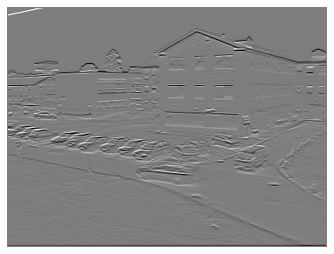

I_y:


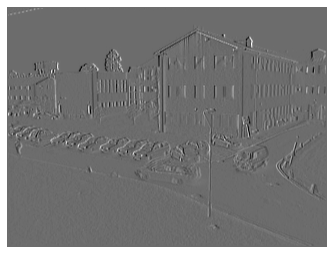

I_t:


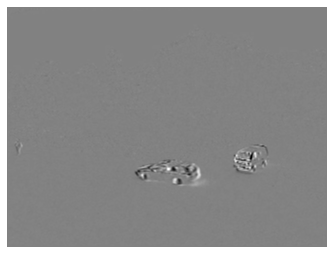

Optical flow field:


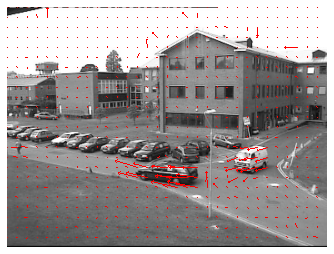

In [2]:
# write your code here

# Lucas-Kanade algorithm for two images and n x n windows (n should be odd)
def lk_optical_flow(img1, img2, n):
    rows, cols = img1.shape # assume same size for images
    
    # typecasting for intermediate summations
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    
    # empty images for the derivatives
    ix = np.zeros((rows, cols), dtype=np.float64) # derivative wrt x
    iy = np.zeros((rows, cols), dtype=np.float64) # derivative wrt y
    it = np.zeros((rows, cols), dtype=np.float64) # derivative wrt t
    
    # compute the derivatives (leave out the border)
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            ix[i, j] = 0.25 * (img1[i+1, j] + img2[i+1, j] + img1[i+1, j+1] + img2[i+1, j+1]) \
                      -0.25 * (img1[i, j] + img2[i, j] + img1[i, j+1] + img2[i, j+1])

            iy[i, j] = 0.25 * (img1[i, j+1] + img2[i, j+1] + img1[i+1, j+1] + img2[i+1, j+1]) \
                      -0.25 * (img1[i, j] + img2[i, j] + img1[i+1, j] + img2[i+1, j]) \
            
            it[i, j] = 0.25 * (img2[i, j] + img2[i+1, j] + img2[i, j+1] + img2[i+1, j+1]) \
                      -0.25 * (img1[i, j] + img1[i+1, j] + img1[i, j+1] + img1[i+1, j+1])
            
    # plot of the normalized derivatives
    print("I_x:"); plot_img_orig(cv2.normalize(ix, None, 0, 255, cv2.NORM_MINMAX))
    print("I_y:"); plot_img_orig(cv2.normalize(iy, None, 0, 255, cv2.NORM_MINMAX))
    print("I_t:"); plot_img_orig(cv2.normalize(it, None, 0, 255, cv2.NORM_MINMAX))
    
    # data structure to store the products of the derivatives
    di = np.zeros((rows, cols, 5), dtype=np.float64)
    
    # compute the elements of the linear system
    di[:,:,0] = ix * ix # this is elementwise multiplication
    di[:,:,1] = iy * iy 
    di[:,:,2] = ix * iy # = iy * ix
    
    di[:,:,3] = -ix * it
    di[:,:,4] = -iy * it
    
    # data structure to store the elements of (A^T A) and (A^T b) of the linear equation system
    ls = np.zeros((rows, cols, 5), dtype=np.float64)
    
    # compute the sums in the windows
    h = int(n / 2) # offset (half window size)
    for i in range(h, rows-h):
        for j in range(h, cols-h):
            nbh = di[i-h:i+h+1, j-h:j+h+1] # n x n window (neighborhood)

            ls[i,j,0] = nbh[:,:,0].sum() # Σ ix * ix
            ls[i,j,1] = nbh[:,:,1].sum() # Σ iy * iy
            ls[i,j,2] = nbh[:,:,2].sum() # Σ ix * iy
            
            ls[i,j,3] = nbh[:,:,3].sum() # Σ -ix * it
            ls[i,j,4] = nbh[:,:,4].sum() # Σ -iy * it
    
    # data structure for the resulting optical flow field
    res = np.zeros((rows, cols, 2), dtype=np.float64) # u and v components (each is one channel)
    
    # optical flow computation
    for i in range(h, rows-h):
        for j in range(h, cols-h):
            a_matrix = np.array([[ls[i,j,0], ls[i,j,2]], [ls[i,j,2], ls[i,j,1]]]) # matrix (A^T A)
            b_vector = np.array([[ls[i,j,3]], [ls[i,j,4]]]) # vector (A^T b)
            
            # least-squares solution of the linear equation system
            vec = np.linalg.lstsq(a_matrix, b_vector, rcond=None)[0]
            res[i,j,0] = vec[0]
            res[i,j,1] = vec[1]
            
    return res

# read images as grayscale images (parameter 0)
img1 = cv2.imread('images/cars_t1.png', 0)
img2 = cv2.imread('images/cars_t2.png', 0)

# compute the optical flow field
of = lk_optical_flow(img1, img2, 10)

# plot the resulting optical flow field
img_of = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB) # convert to RGB
rows, cols = img2.shape

fac = 10.0 # scaling factor for the length of the arrows
for i in range(0, rows, 10):
    for j in range(0, cols, 10):
        pt1 = (int(j), int(i)) # note that x is the horizontal axis in opencv
        pt2 = (int(j + fac*of[i, j, 1]), int(i + fac*of[i, j, 0]))

        cv2.arrowedLine(img_of, pt1, pt2, color=(255, 0, 0))
        
print("Optical flow field:");
plot_img_orig(img_of)

Note: For a few points, the optical flow is apparently incorrectly determined. This is due to the low texture in these areas. The points can usually be excluded by checking the eigenvalues of the matrix $\mathbf{A}^T \mathbf{A}$. These are expected to be very small here ($\lambda_1 < \tau$ and $\lambda_2 < \tau$, where $\tau$ is a threshold such as $0.01$).